In [2]:
# Exchange fluxes above the sill
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
sd = 1 # Sill depth
#/Volumes/Extreme SSD/MITgcm outputs
#/work/oceans/wbao/MITgcm_results/iceplume/fjord_test
#/Users/weiyangbao/.CMVolumes/Caviness-group/iceplume/
file1 = xr.open_dataset('/work/oceans/wbao/MITgcm_results/iceplume/2_Qsg_maxhs/state_' + str(format(sd,'03d')) + '.nc')
file2 = xr.open_dataset('/work/oceans/wbao/MITgcm_results/iceplume/2_Qsg_maxhs/icefrntA_' + str(format(sd,'03d')) + '.nc')
T0 = 0 
Tn = len(file1.T) # T0=275~Tn includes N=5 tidal periods (T=12.4 h)
# X=range(1,120), Xp1=range(1,121), Y=range(30,39), Yp1=range(30,40)
#state1 = file1.isel(T=range(T0,Tn)) # Remove the boundary walls and the shelf region
state1 = file1.isel(T=~file1.get_index("T").duplicated())
grid1 = xr.open_dataset('/work/oceans/wbao/MITgcm_results/iceplume/2_Qsg_maxhs/grid_' + str(format(sd,'03d')) + '.nc')
#file2 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/qf-tide-hourly/state_' + str(format(sd,'03d')) + '.nc')
#state2 = file2.isel(X=range(120), Xp1=range(121), Y=range(30,39), Yp1=range(30,40)) # Remove the boundary walls and the shelf region
#grid2 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/qf-tide-hourly/grid_' + str(format(sd,'03d')) + '.nc')

time1 = state1.T.data / 86400
#time2 = state2.T.data / 86400
xs = 235
u1 = state1.U.data[:,:,:,xs]
#u2 = state2.U.data[:,:,:,xs]
#u = state1.U.data[T0,:,5,xs]
dis = state1.X.data
xp1 = state1.Xp1.data

# Area = np.empty([50, 9]) # Cross Y direction
# Area[:10, :] = 100
# Area[10:20, :] = 200
# Area[20:30, :] = 300
# Area[30:40, :] = 800
# Area[40:, :] = 1600

Area = np.empty([90, 10]) # Cross Y direction
Area[:20, :] = 400
Area[20:50, :] = 800
Area[50:, :] = 1200

pt1 = state1.Temp.data[:,:,:,xs]
#pt2 = state2.Temp.data[:,:,:,xs]


s1 = state1.S.data[:,:,:,xs]
#s2 = state2.S.data[:,:,:,xs]



HFacW = grid1.HFacW.data[:,35:45,xs] # vertical fraction of open cell at West face
HFacC = grid1.HFacC
# volume = ds.hFacC * ds.drF * ds.rA
#state1.Xp1.data[72], state1.X.data[71]
#len(time), time
#time1
pt1[0,0,40]

10.0

In [5]:
Ut = state1.U.data[90:,:,35:45,:].mean(axis=(0,2))
Ut[:,120]

array([-1.64009016e-02, -1.62994098e-02, -1.60577800e-02, -1.55614885e-02,
       -1.46453045e-02, -1.31067457e-02, -1.07499165e-02, -7.46640982e-03,
       -3.34020657e-03,  1.33751438e-03,  6.12923084e-03,  1.06370924e-02,
        1.46230096e-02,  1.79759506e-02,  2.06290949e-02,  2.26914510e-02,
        2.41850857e-02,  2.52365917e-02,  2.58694030e-02,  2.60654259e-02,
        2.53226794e-02,  2.26606205e-02,  1.90067608e-02,  1.53140360e-02,
        1.19248033e-02,  8.93036928e-03,  6.22739736e-03,  3.75937345e-03,
        1.52982166e-03, -4.59911156e-04, -2.25891755e-03, -3.89626366e-03,
       -5.29900892e-03, -6.50793593e-03, -7.45829940e-03, -8.24349280e-03,
       -8.86444468e-03, -9.40162409e-03, -9.58999433e-03, -9.86661948e-03,
       -9.60969832e-03, -9.23660304e-03, -8.69044010e-03, -7.98607804e-03,
       -7.07780244e-03, -5.97964879e-03, -4.74749552e-03, -3.55595513e-03,
       -2.46156333e-03, -1.52134092e-03, -6.18266640e-04, -3.47242130e-05,
        1.94584209e-04,  

In [ ]:
fig0, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(9,9))
ts1 = time1 * 86400
ts2 = time2 * 86400
zi = 40
ax1.plot(ts1,u1[:,zi,40],label="no restart")
ax1.plot(ts2,u2[:,zi,40],lw=.5,label="with restart")
ax1.set_title('$U$', size=15, weight='bold')
ax1.legend(loc = 'best', fontsize=15)
ax1.tick_params(labelsize=15)
ax1.xaxis.set_visible(False)
ax1.set_ylabel('($m/s$)', size=15)


ax2.plot(ts1,pt1[:,zi,40], ts2, pt2[:,zi,40])
ax2.set_title('$Temp$', size=15, weight='bold')
#ax2.legend(loc = 'best', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.xaxis.set_visible(False)
ax2.set_ylabel('($^{\circ}C$)', size=15)



ax3.plot(ts1,s1[:,zi,40], ts2, s2[:,zi,40])
ax3.set_title('$Sal$', size=15, weight='bold')
#ax2.legend(loc = 'best', fontsize=15)
ax3.tick_params(labelsize=15)
ax3.set_ylabel('($psu$)', size=15)

ax3.set_xlabel('Time (s)', size=15)

In [9]:
idx = 130
#dis[idx], xp1[idx], grid1.HFacC.data[:,35,idx]
#grid1.dyF
vol = grid1.HFacC * grid1.drF * grid1.rA # Z Y X
areaC = grid1.HFacC * grid1.drF * grid1.dyF # Z Y X
areaW = grid1.HFacW * grid1.drF * grid1.dyG # Z Y Xp1
temp = state1.Temp.data
s = state1.S.where(HFacC>0)
U = state1.U.where(grid1.HFacW>0)
sW = np.where(HFacC[-1,40,1:] == 0)[-1][0] # Sill west edge index
sE = np.where(HFacC[-1,40,1:] == 0)[-1][-1] # Sill east edge index
sC = np.ceil((sW+sE)/2).astype(int) # Sill crest index (178)
#state1.U.data[5,:,40,178], U[5,:,40,178]
#dis[sW], dis[sE], dis[sC]
#dis[[sW,sC,sE,259]]
#Q = u1[2,:,:] * areaW[:,:,xs].data
sW, sE, sC, U[22,:,40,178]

(120,
 235,
 178,
 <xarray.DataArray 'U' (Z: 90)>
 array([-0.00594784, -0.00658388, -0.00771251, -0.00898497, -0.01032866,
        -0.01203887, -0.01415795, -0.01663958, -0.01929444, -0.02202246,
        -0.02420954, -0.02494843, -0.02504551, -0.02376466, -0.02071353,
        -0.01748765, -0.01283002, -0.01642662, -0.0085748 , -0.01095997,
         0.03238993,  0.0486978 ,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
 

In [10]:
Q1out = np.empty(len(time1))
#Q2out = np.empty(len(time))
Q1in = np.empty(len(time1))
#Q2in = np.empty(len(time))
for t in range(len(time1)):
    Q1 = u1[t,:,:] * areaW.data[:,:,xs]
    #Q2 = u2[t,:,:] * Area * HFacW
    Q1out[t] = Q1[Q1 > 0].sum()
    #Q2out[t] = Q2[Q2 > 0].sum()
    Q1in[t] = Q1[Q1 < 0].sum()
    #Q2in[t] = Q2[Q2 < 0].sum()

np.mean(Q1out[1]+Q1in[1])
#Q1in[[35,38]], Q1out[[35,38]]

25.896325615718354

array([ 0.        , 25.89632562, 31.15043293, 22.18097496, 22.18670374,
       25.21103477, 26.38418848, 25.90621024, 25.49872278, 24.76787378,
       24.63729335, 24.70043502, 24.60871636, 24.94697802, 25.34057201,
       25.3266809 , 24.95951842, 24.76169991, 24.81366807, 24.94404058,
       25.1530919 , 25.13720312, 24.92676389, 24.8762652 , 24.94747409,
       25.05657887, 25.0660672 , 24.9551926 , 24.92906717, 24.98884827,
       25.04224468, 25.00715021, 24.94406562, 24.96372964, 25.017007  ,
       25.01846435, 24.96763113, 24.9622812 , 25.00356334, 25.01750853,
       24.97953271, 24.96356454, 24.99721987, 25.01118876, 24.98037216,
       24.96432403, 24.99062377, 25.00771876, 24.98272394, 24.97376178,
       24.99480769, 24.99906391, 24.97617795, 24.97707907, 24.9959451 ,
       24.98564177, 24.97658655, 24.98520486, 24.99792175, 24.98609251,
       24.9800329 , 24.98895291, 24.99285814, 24.98049951, 24.98285888,
       24.98716774, 24.98714213, 24.98099737, 24.98877898, 24.99

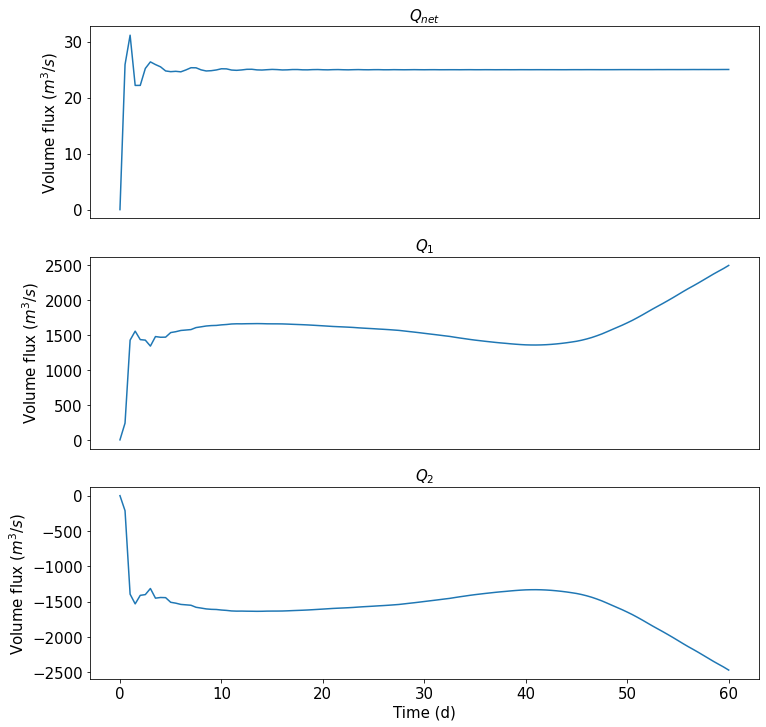

In [11]:
#fig_path = "/Users/weiyangbao/Documents/Results_Figs/VolumeTest/"
#if not os.path.exists(fig_path):
#    os.makedirs(fig_path)

fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(12,12)) 
ax1.plot(time1,Q1in+Q1out, label='ConserveMass OFF')
#ax1.plot(time,Q2in+Q2out, label='ConserveMass ON')
ax1.set_title('$Q_{net}$', size=15, weight='bold')
#ax1.legend(loc = 'best', fontsize=15)
ax1.tick_params(labelsize=15)
ax1.xaxis.set_visible(False)
ax1.set_ylabel('Volume flux ($m^3/s$)', size=15)


ax2.plot(time1,Q1out, label='ConserveMass OFF')
#ax2.plot(time,Q2out, label='ConserveMass ON')
#ax2.axvline(x=275, color='b',lw=2)

ax2.set_title('$Q_1$', size=15, weight='bold')
#ax2.legend(loc = 'best', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.xaxis.set_visible(False)
ax2.set_ylabel('Volume flux ($m^3/s$)', size=15)


ax3.plot(time1,Q1in, label='ConserveMass OFF')
#ax3.plot(time,Q2in, label='ConserveMass ON')
#ax3.axvline(x=275, color='b',lw=2)
ax3.set_title('$Q_2$', size=15, weight='bold')
#ax3.legend(loc = 'best', fontsize=15)
ax3.tick_params(labelsize=15)

ax3.set_xlabel('Time (d)', size=15)
ax3.set_ylabel('Volume flux ($m^3/s$)', size=15)
Q1in+Q1out

In [ ]:
N = np.arange(1,41,1)
N / 1.03505, time1[-1], time1[90]

In [ ]:
def volflux_ts(file, xidx):
    State01 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf700_strat_high/state_' + str(format(file,'03d')) + '.nc')
    Grid01 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf700_strat_high/grid_' + str(format(file,'03d')) + '.nc')
    T0 = 1 # Start time
    Tn = len(State01.T) # End time
    State = State01.isel(X=range(1,120), Xp1=range(1,121), Y=range(30,39), T=range(T0,Tn))
    Grid = Grid01.isel(X=range(1,120), Xp1=range(1,121), Y=range(30,39))    
    
    time = State.T.data / 86400
    
    Area = np.empty([50, 9]) # Cross Y direction
    Area[:10, :] = 100
    Area[10:20, :] = 200
    Area[20:30, :] = 300
    Area[30:40, :] = 800
    Area[40:, :] = 1600

    HFacW = Grid.HFacW.data[:,:,xidx] # vertical fraction of open cell at West face
    
    Q1 = np.empty(len(time))
    Q2 = np.empty(len(time))
    for t in range(len(time)):
        Q = State.U.data[t,:,:,xidx] * Area * HFacW
        Q1[t] = Q[Q > 0].sum()
        Q2[t] = Q[Q < 0].sum()
    
    return time, Q1, Q2

In [ ]:
prof = np.array([1,2,3,4])
hsr = np.array([9, 12, 15, 18]) / 150
xi = 47
fig1 = plt.figure(figsize=(10,10))
fig1.tight_layout()

ax1 = fig1.add_subplot(211)
#ax1.axvline(x=4.8, color='k',lw=1.5,ls='--')
ax1.set_xlim([0, 30])
ax1.set_title(r'(a) Down fjord', loc='center', size=15)
#ax1.xaxis.set_visible(False)
ax1.set_ylabel(r'Volume Flux [$m^3/s$]', size=15)
ax1.grid(True)
ax1.set_xticklabels([])
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)



ax2 = fig1.add_subplot(212)
ax2.set_xlim([0, 30])
ax2.set_title(r'(b) Up fjord', loc='center', size=15)
ax2.set_ylabel(r'volume Flux [$m^3/s$]', size=15)
ax2.set_xlabel('Time [d]', size=15)
ax2.grid(True)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

#ax3 = fig1.add_subplot(313)
#ax3.set_xlim([0, 30])
#ax3.set_title(r'(c) Net', loc='center', size=15)
#ax3.set_xlabel('Time [d]', size=15)
#ax3.set_ylabel('Heat Flux [J/s]', size=15)
#ax3.grid(True)
#ax3.spines["top"].set_visible(False)
#ax3.spines["right"].set_visible(False)

for i in range(len(prof)):
    ot, qp, qn = volflux_ts(prof[i],xi)
    
    ax1.plot(ot, qp, lw=2, label=str(prof[i]))
    ax1.legend(title=r'case', loc='right', fontsize=12)
    
    ax2.plot(ot, qn, lw=2, label=str(prof[i]))
    ax2.legend(title=r'case', loc='right', fontsize=12)
    
    #ax3.plot(ot, advhp+advhn, lw=2, label=str(hsr[i]))
    #ax3.legend(title=r'$h_s/h$', loc='right', fontsize=12)

In [ ]:
#fig_path = "/Users/weiyangbao/Documents/Results_Figs/VolumeTest/"

fig_path ="/home/1959/Jupyter_Figs/Qsg500n_004/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

fig.savefig(fig_path + '/Q_test.png', dpi=200, bbox_inches='tight')    